# Prototype calculation of cabelling and mixing of density from LLC4320 data
[Podaac description](https://podaac.jpl.nasa.gov/announcements/2021-04-30-Pre-SWOT-L4-Hourly-MITgcm-LLC4320-Native-1/48-degree-Grid-Oceanographic-V1.0-Datasets-Release)

In [92]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [93]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.d56ec45541224c418e0b67b4b884139f/status,


In [17]:
cluster.close()
client.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
import xmitgcm
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from typing import Annotated

In [47]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = open_catalog(url)
sst  = cat["LLC4320_SST"].to_dask()
sss  = cat["LLC4320_SSS"].to_dask()
grid_ds = cat["LLC4320_grid"].to_dask()

In [3]:
merge = xr.merge([sst, sss.SSS, grid])

In [4]:
ds = faces_dataset_to_latlon(merge, metric_vector_pairs=[])
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, j: 12960, time: 9030, i_g: 17280, j_g: 12960,
              k_p1: 2)
Coordinates: (12/37)
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    ...       ...
    k_l      int64 1
    k_u      int64 1
    rA       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Data variables:
    SST      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [73]:
ds_rechunked = ds.chunk({'time':1, 'j':12960, 'i':17280, 'i_g':17280, 'j_g':12960})

In [74]:
ds_rechunked['SSD'] = fastjmd95.rho(ds_rechunked.SSS, ds_rechunked.SST, 0)

# BIHARMONIC/LAPLACIAN ROUTINE

## Biharmonic (borrowed from Paige/POP data)

In [45]:
ds.dyG

<xarray.DataArray 'dyG' (j: 12960, i_g: 17280)>
dask.array<concatenate, shape=(12960, 17280), dtype=float32, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
    PHrefC   float32 15.4
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    ...       ...
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Attributes:
    coordinate:     YC XG
    long_name:      cell y size
    standard_name:  cell_y_size_at_u_location
    units:          m

In [44]:
ds.dxG

<xarray.DataArray 'dxG' (j_g: 12960, i: 17280)>
dask.array<concatenate, shape=(12960, 17280), dtype=float32, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    PHrefC   float32 15.4
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    ...       ...
    dyC      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rAs      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Attributes:
    coordinate:     YG XC
    long_name:      cell x size
    standard_name:  cell_x_size_at_v_location
    units:          m

In [9]:
#from Paige's code: The biharmonic horiz diffusion routine
#https://github.com/ocean-transport/cesm-air-sea/blob/master/biharmonic_tendency.ipynb

# raw grid geometry
work1 = (ds['dxG'].values / #m
         ds['dyG'].values) #m
tarea = ds['rA'].values # m**2
tarea_r = np.ma.masked_invalid(tarea**-1).filled(0.) # 1/area of T cells
dtn = work1*tarea_r # coefficient of north point in 5-point stencil
dts = np.roll(work1,-1,axis=0)*tarea_r # coeff of south point in 5-point stencil

work1 = (ds['HTE'].values / # HTE: cell widths on East sides of T cells (cm)
         ds['HUS'].values) # HUS: cell widths on South sides of U cells (cm)
dte = work1*tarea_r # coeff of east point in 5-point stencil
dtw = np.roll(work1,-1,axis=1)*tarea_r # coeff of west point in 5-point stencil

kmt = ds['KMT'].values # KMT: k-index of deepest grid cell on T grid (where k is the depth level)

# boundary conditions
kmt_ = kmt > 1 # k=1 is the surface, so this sets all subsurface levels to True
kmtn = np.roll(kmt_,-1,axis=0)
kmts = np.roll(kmt_,1,axis=0)
kmte = np.roll(kmt_,-1,axis=1)
kmtw = np.roll(kmt_,1,axis=1)
cn = np.where(kmt_ & kmtn, dtn, 0.) # where both kmt_ and kmtn are True, set value equal to dtn, else set to 0 -->
# --> essentially sets up a mask for land/surface points
cs = np.where(kmt_ & kmts, dts, 0.)
ce = np.where(kmt_ & kmte, dte, 0.)
cw = np.where(kmt_ & kmtw, dtw, 0.)

# Find single index where there's a min of squared latitude --> so this is probably the lat of equator
j_eq = np.argmin(ds['ULAT'].values[:,0]**2) # ULAT: array of U-grid latitudes (degrees North)
j_eq.shape

# Area of T cells / area of U cell at the equator, all raised to 1.5 power
# this is because the mixing scheme assumes the grid spacing that is at the equator, so coeffs are 1 at equator and reduce toward the poles
ahf = (tarea / ds['UAREA'].values[j_eq, 0])**1.5 # UAREA: area of U cells (cm**2)
ahf[kmt <= 1] = 0.

def laplacian(T, cn, cs, ce, cw):
    cc = -(cn + cs + ce + cw) # cn,cs,ce,cw are coeffs for laplacian
    return (
        cc * T +
        cn * np.roll(T, -1, axis=-2) +
        cs * np.roll(T, 1, axis=-2) +
        ce * np.roll(T, -1, axis=-1) +
        cw * np.roll(T, 1, axis=-1)          
    )

def biharmonic_tendency(T, ahf, cn, cs, ce, cw):
    ah=-3e17 # horizontal tracer mixing coefficient 
    d2tk = ahf * laplacian(T, cn, cs, ce, cw) # take laplacian of T, multiplying by grid factor due to equator
    return ah * laplacian(d2tk, cn, cs, ce, cw) # take laplacian of laplacian of T

KeyError: 'HTE'

In [ ]:
arr = [ahf, cn, cs, ce, cw]
for arr_type in arr:
    if str(type(arr_type)) == "<class 'numpy.ndarray'>":
        print("True")
    else:
        print("not ndarray")


## Laplacian borrowed from GCM-Filters MOM5 routine

In [84]:
wet_mask = (ds_rechunked.hFacC > 0)
dxc = ds_rechunked.dxC #dxt equivalent
dyc = ds_rechunked.dyC #dyt equivalent
dxg = ds_rechunked.dxG #dxu equivalent
dyg = ds_rechunked.dyG #dyu equivalent
area = ds_rechunked.rA
kappa = 10 #m^2/s

In [77]:
import xgcm
grid = xgcm.Grid(ds_rechunked.drop_dims('time'), coords={'X': {'center': 'i', 'left': 'i_g'}, 
                             'Y': {'center': 'j', 'left': 'j_g'}},
                             periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center

In [85]:
@xgcm.as_grid_ufunc(dask="parallelized")
def Laplacian(
    wet_mask: Annotated[np.ndarray, "(Y:center, X:center)"],
    dxc:      Annotated[np.ndarray, "(Y:center, X:left)"],
    dyc:      Annotated[np.ndarray, "(Y:left, X:center)"],
    dxg:      Annotated[np.ndarray, "(Y:left, X:center)"],
    dyg:      Annotated[np.ndarray, "(Y:center, X:left)"],
    area:     Annotated[np.ndarray, "(Y:center, X:center)"],
    tracer:   Annotated[np.ndarray, "(Y:center, X:center)"],
) ->          Annotated[np.ndarray, "(Y:center, X:center)"]:
    
    """Laplacian routine for MOM5 adapted to MITgcm LLC4320.
    MOM5 uses a Northeast convention B-grid, where velocity point U(i,j) is NE of tracer point T(i,j).
    MITgcm uses a C-grid where velocity point U(i_g, j_g) is on the cell faces and tracer point T(i,i)
    is in the cell center.
    
    Attributes
    __________
    For information on MITgcm discretization see: 
    https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#spatial-discretization-of-the-dynamical-equations
    
    For information on MITfcm horizontal grid see: https://mitgcm.readthedocs.io/en/latest/algorithm/horiz-grid.html
    
    wet_mask: Mask array, 1 for ocean, 0 for land
    dxc: width in x see fig 2.8 b), model diagnostic dxC
    dyc: height in y see fig 2.8 b), model diagnostic dyC
    dxu: width in x see fig 2.8 a), model diagnostic dxG
    dyu: height in see fig 2.8 a), model diagnostic dyG
    area_t: area of T-cell, dxt*dyt
    """    
    #x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1)
    #y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)
    y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1) #order of index: (j,i)?
    x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)

    tracer = np.nan_to_num(tracer)
    
    fx = 2 * (np.roll(tracer, -1, axis=-2) - tracer)
    dxg_interp = grid.interp(dxg, 'X')
    fx /= dxg_interp + np.roll(dxg_interp, 1, axis=-1)
    fx *= x_wet_mask
    
    fy = 2 * (np.roll(tracer, -1, axis=-1) - tracer)
    dyg_interp = grid.interp(dyg, 'Y', bounadry='fill')
    fy /= dyg_interp + np.roll(dyg_interp, 1, axis=-2)
    fy *= y_wet_mask

    out1 = fx * 0.5 * (dyc + np.roll(dyc, -1, axis=-2))
    out1 -= (
        np.roll(fx, 1, axis=-2) * 0.5 * (dyc + np.roll(dyc, 1, axis=-2))
    )
    out1 /= area

    out2 = fy * 0.5 * (dxc + np.roll(dxc, -1, axis=-1))
    out2 -= (
        np.roll(fy, 1, axis=-1) * 0.5 * (dxc + np.roll(dxc, 1, axis=-1))
    )
    out2 /= area
    return out1 + out2

In [80]:
axis = 7*[('Y','X')]

# 1) Calculate tendency of SST and and SSS from mixing <a class="anchor" id="first-bullet"> </a>

In [95]:
SST_lap = kappa * Laplacian(grid, wet_mask, dxc, dyc, dxg, dyg, area, ds_rechunked.SST, axis=axis)
SSS_lap = kappa * Laplacian(grid, wet_mask, dxc, dyc, dxg, dyg, area, ds_rechunked.SSS, axis=axis)

In [97]:
SST_lap

<xarray.DataArray (time: 9030, j: 12960, i: 17280)>
dask.array<mul, shape=(9030, 12960, 17280), dtype=int64, chunksize=(1, 12960, 17280), chunktype=numpy.ndarray>
Coordinates: (12/19)
    PHrefC   float32 15.4
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    drF      float32 1.14
    k        int64 1
    ...       ...
    SN       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    hFacC    (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(12960, 17280), meta=np.ndarray>

In [ ]:
SST_lap.isel(time=0).plot()

TypeError: All data arguments must be either a DataArray or Dictionary Got <class 'numpy.ndarray'>.

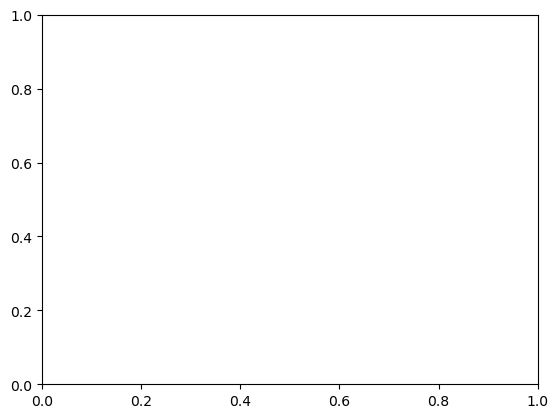

In [100]:
plt.plot(SST_lap.isel(time=0))

# 2) Convert to density tendency <a class="anchor" id='second-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S)
$$

In [41]:
rho = ds.SSD

In [42]:
rho

<xarray.DataArray 'SSD' (time: 9030, j: 12960, i: 17280)>
dask.array<transpose, shape=(9030, 12960, 17280), dtype=float64, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4
    ...       ...
    hFacC    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rA       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>

In [7]:
drhodt = xr.apply_ufunc(fastjmd95.drhodt, ds.SSS, ds.SST, 0,
                        output_dtypes=[ds.SST.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()
drhods = xr.apply_ufunc(fastjmd95.drhods, ds.SSS, ds.SST, 0,
                        output_dtypes=[ds.SSS.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()

In [13]:
dens_tend = (drhodt * SST_lap + drhods * SSS_lap)
dens_tend

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<add, shape=(240, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    st_ocean  float64 5.034
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

[Back to top](#top)

# 3) Decompose into the following form <a class='anchor' id='third-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) = M(\rho) + C
$$

You can calculate $C$ as

$$
C = \frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) - M(\rho)
$$

In [43]:
rho_lap = kappa * Laplacian(grid, wet_mask, dxc, dyc, area, rho, dxg, dyg, axis=axis)

rho_lap

ValueError: Mismatch between signature and input argument 1: Signature specified data to lie at Axis Position (X:center), but the corresponding grid coordinate i does not appear in argument<xarray.DataArray 'dxC' (j: 12960, i_g: 17280)>
dask.array<concatenate, shape=(12960, 17280), dtype=float32, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
    PHrefC   float32 15.4
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    ...       ...
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Attributes:
    coordinate:     YC XG
    long_name:      cell x size
    standard_name:  cell_x_size_at_u_location
    units:          m

In [15]:
cabbeling = dens_tend - rho_bih

In [16]:
cabbeling

<xarray.DataArray (time: 14965, nlat: 2400, nlon: 3600)>
dask.array<sub, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

In [18]:
selection = dict(xt_ocean=slice(-75,-25), yt_ocean=slice(25,60))
kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}

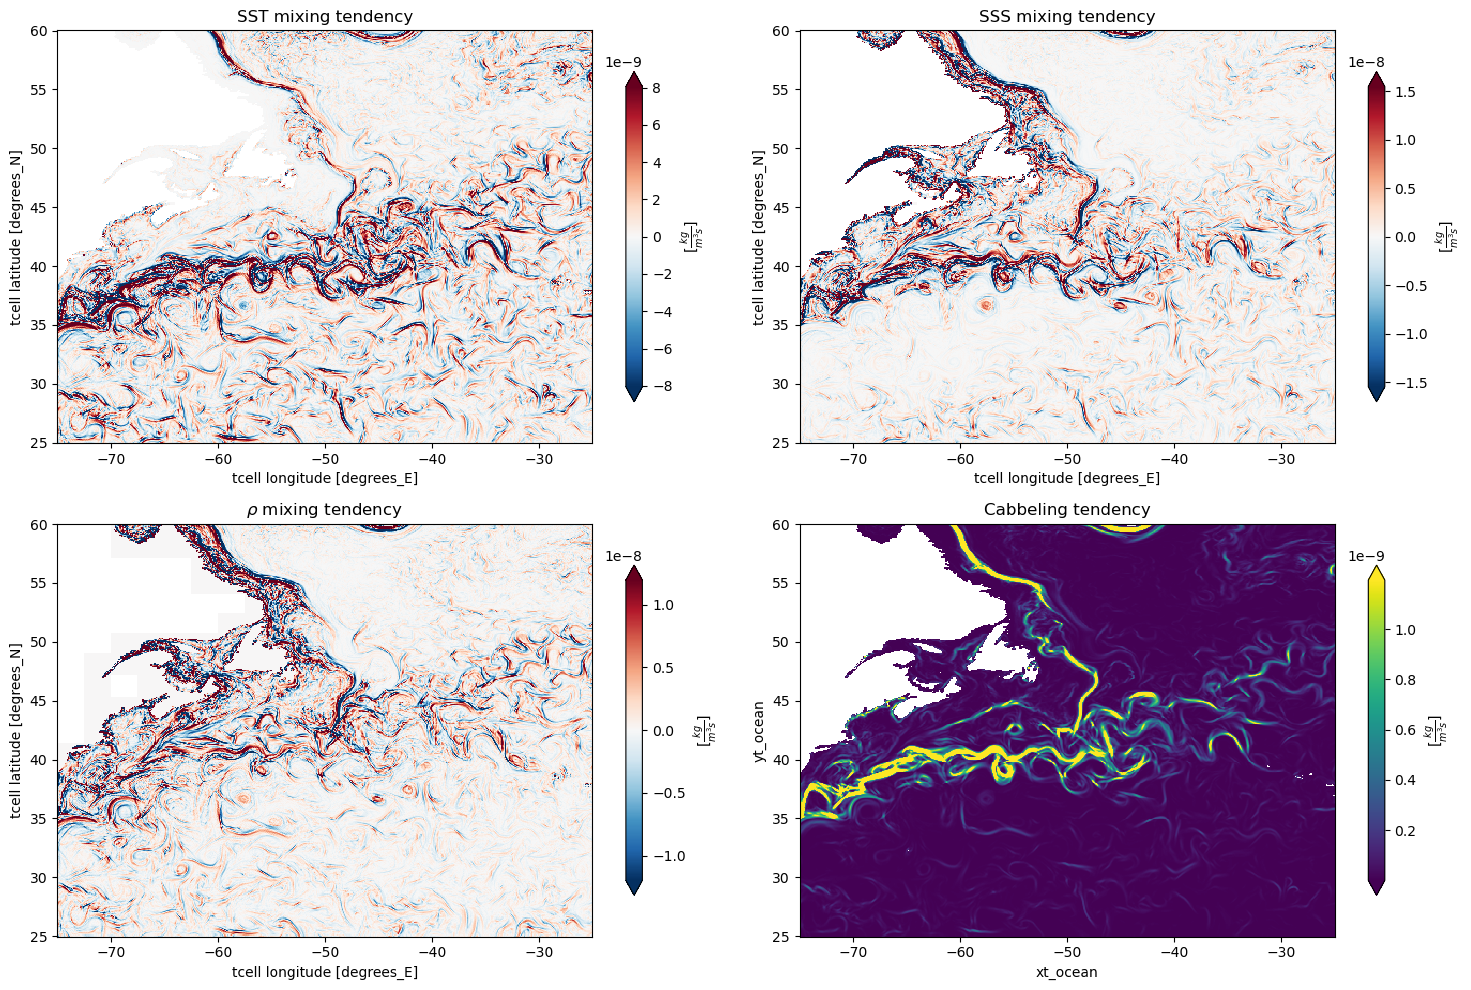

In [21]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(15,10))

(SST_lap*drhodt).isel(time=0).sel(**selection).plot(robust=True, ax=ax[0,0], 
                                 cbar_kwargs=kwargs)
ax[0,0].set_title('SST mixing tendency')
(SSS_lap*drhods).isel(time=0).sel(**selection).plot(robust=True, ax=ax[0,1], 
                                 cbar_kwargs=kwargs)
ax[0,1].set_title('SSS mixing tendency')
(rho_lap).isel(time=0).sel(**selection).plot(robust=True, ax=ax[1,0], 
                                 cbar_kwargs=kwargs)
ax[1,0].set_title(r'$\rho$ mixing tendency')
(cabbeling).isel(time=0).sel(**selection).plot(robust=True, ax=ax[1,1], 
                                   cbar_kwargs=kwargs)
ax[1,1].set_title('Cabbeling tendency')

plt.tight_layout();

## 4) Save the four terms to dataset <a class="anchor" id="fourth-bullet"> </a>

In [ ]:
client.restart()

In [8]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [9]:
drhodts = xr.merge([drhodt.rename('drhodt'), drhods.rename('drhods')])

In [25]:
drhodts.time.isel(time=slice(0,4320))

<xarray.DataArray 'time' (time: 4320)>
array(['2011-09-13T00:00:00.000000000', '2011-09-13T01:00:00.000000000',
       '2011-09-13T02:00:00.000000000', ..., '2012-03-10T21:00:00.000000000',
       '2012-03-10T22:00:00.000000000', '2012-03-10T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-03-10T23:00:00

In [26]:
drhodt.isel(time=slice(0,4320)).nbytes/1e9

3869.835264

In [29]:
drhodt = drhodt.to_dataset(name='drhodt')
drhods = drhods.to_dataset(name='drhods')

In [48]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.cd4e11de84374384b207055ed6824663/status,


In [41]:
24*30

720

In [47]:
drhodt.isel(time=slice(0,720)).nbytes/1e9

644.97279168

In [49]:
drhodt_1mo = drhodt.isel(time=slice(0,720))
drhodts_1mo = drhods.isel(time=slice(0,720))

In [ ]:
#uploading drhodt tendency for first month
gcsmap_drhodt_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/drhodt_1mo.zarr')
drhodt_1mo.to_zarr(gcsmap_drhodt_tendencies, mode='w')

In [ ]:
#uploading drhods tendency for first month
gcsmap_drhods_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/drhods_1mo.zarr')
drhods_1mo.to_zarr(gcsmap_drhods_tendencies, mode='w')

In [55]:
cluster.close()
client.close()